In [31]:
import pandas as pd
import numpy as np
import os
import csv
import ast
from collections import Counter
import geopandas as gpd
import h5py
from datetime import datetime, timedelta
#### personal packages####
import sys
##### for plotting # ##
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

In [32]:
# df_sed = pd.read_csv("../Data/tract_data2020.csv")
df_sed = pd.read_csv("../Data/tract_data2021.csv")
### whole ny state where state = 36
df_zip_mod = pd.read_csv("../results/modzcta_zip_counts.csv")
df_nyc = df_sed.merge(df_zip_mod, left_on = "GEOID", right_on = "ZCTA", how = "left")

In [33]:
df_nyc.columns

Index(['GEOID', 'weighted_estimated_average_age', 'median_age', 'Black',
       'Hispanic', 'Household_income', 'Bachelor', 'Household_num',
       'Population', 'No_health_insurance', 'No_vehicles', 'ZCTA', 'MODZCTA',
       'ZCTA_str', 'zip_code', 'Value', 'Count', 'modzcta_count', 'mod_idx'],
      dtype='object')

In [34]:
aggregated_data = df_nyc.groupby('MODZCTA').agg({
    'weighted_estimated_average_age': 'mean',
    'median_age': 'mean',
    'Black': 'sum',
    'Hispanic': 'sum',
    'Household_income': 'mean',
    'Bachelor': 'sum',
    'Household_num': 'sum',
    'Population': 'sum',
    'No_health_insurance': 'sum', 
    'No_vehicles': 'sum',
}).reset_index()

In [35]:
aggregated_data['No_health_insurance_rate'] = aggregated_data['No_health_insurance']/aggregated_data['Population']
aggregated_data['No_vehicles_rate'] = aggregated_data['No_vehicles']/aggregated_data['Household_num']

In [36]:
aggregated_data.to_csv('../data/sed_nyc_modzcta_2021_v2.csv',index=False)

## Policy index

In [38]:
df_policies_2020 = pd.read_csv("../data/OxCGRT_USA_differentiated_withnotes_2020.csv", low_memory=False)
df_policies_2021 = pd.read_csv("../data/OxCGRT_USA_differentiated_withnotes_2021.csv", low_memory=False)

In [39]:
df_poli_indx_20 = df_policies_2020[['RegionName', 'Date', 'StringencyIndex_WeightedAverage']]
df_poli_index_ny_20 = df_poli_indx_20[df_poli_indx_20['RegionName']=='New York']

df_poli_indx_21 = df_policies_2021[['RegionName', 'Date', 'StringencyIndex_WeightedAverage']]
df_poli_index_ny_21 = df_poli_indx_21[df_poli_indx_21['RegionName']=='New York']

In [40]:
df_poli_ny = pd.concat([df_poli_index_ny_20, df_poli_index_ny_21])
len(df_poli_ny) ### start from sunday and it is a daily data we have to convert it to weekly data with the average of the week
df_poli_ny['Date'] = pd.to_datetime(df_poli_ny['Date'],format='%Y%m%d')
start_date = '2020-02-24' ### monday in visit data 2020-03-01 is a Sunday in the data
### it accounts for the day and the 7 days ahead
end_date = '2021-02-15' ###monday in visit data 2021-02-14 is Sunday in the data

In [41]:
mask = (df_poli_ny['Date'] >= start_date) & (df_poli_ny['Date'] <= end_date)
df_poli_ny_s = df_poli_ny.loc[mask]
df_poli_ny_s.set_index('Date', inplace=True)

In [42]:
stringency_7 = df_poli_ny_s['StringencyIndex_WeightedAverage'].rolling(window=7).mean()
stringency_wk = pd.DataFrame(stringency_7[stringency_7.index.weekday == 6])

<Axes: xlabel='Date'>

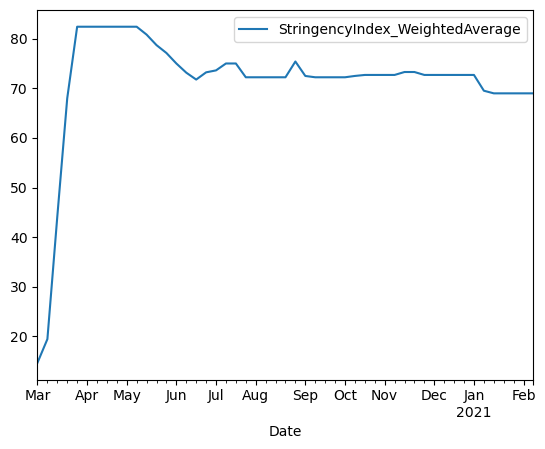

In [43]:
stringency_wk.plot()

In [44]:
stringency_wk['week'] = range(len(stringency_wk))
len(stringency_wk)

In [45]:
stringency_wk.to_csv("../Data/stringency_index_ny_wk.csv")